# Purpose
1. 請為客戶進行貼標，並依其特性進行命名，以幫助行銷部門推出新產品和制定行銷方式。
2. 請先進行降維後再分群(依你的判斷選擇降維和分群的方法)

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. import data

In [3]:
df = pd.read_csv('segmentation_data.csv')
df.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


#### ID：顯示客戶的唯一標識。

#### Sex：
0：男性        
1：女性        

#### Marital status：客戶的婚姻狀況。
0：單人        
1：非單身（離婚/分居/已婚/喪偶）        

#### Age：客戶的年齡（以年為單位），計算方法為當年減去創建數據集時客戶的出生年份
18 最小值（數據集中觀察到的最低年齡）        
76 最大值（數據集中觀察到的最高年齡）        

#### Education：客戶的教育水準。
0：其他/未知        
1：高中        
2：大學        
3：研究生院        

#### Income：客戶以美元自我報告的年收入。
35832 最小值（數據集中觀察到的最低收入）        
309364 最大值（數據集中觀察到的最高收入）        

#### Occupation ：客戶的職業類別。
0：失業 / unskilled        
1：skilled employee / official        
2：management / self-employed / highly qualified employee / officer        

#### Settlement size：客戶居住城市的規模。
0：小城市        
1：中等城市        
2：大城市        

In [5]:
df.describe().round(2).reset_index(level=0)

,index,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,count,2.000000e+03,2000.00,2000.0,2000.00,2000.00,2000.00,2000.00,2000.00
1,mean,1.000010e+08,0.46,0.5,35.91,1.04,120954.42,0.81,0.74
2,std,5.774900e+02,0.50,0.5,11.72,0.60,38108.82,0.64,0.81
3,min,1.000000e+08,0.00,0.0,18.00,0.00,35832.00,0.00,0.00
4,25%,1.000005e+08,0.00,0.0,27.00,1.00,97663.25,0.00,0.00
5,50%,1.000010e+08,0.00,0.0,33.00,1.00,115548.50,1.00,1.00
6,75%,1.000015e+08,1.00,1.0,42.00,1.00,138072.25,1.00,1.00
7,max,1.000020e+08,1.00,1.0,76.00,3.00,309364.00,2.00,2.00


In [6]:
print('男女人數')
df.groupby(by='Sex',as_index=False).size()\
  .rename({'size':'cnt'}, axis=1)


男女人數


,Sex,cnt
0,0,1086
1,1,914


In [7]:
# 1. 讀取與標準化
df = pd.read_csv('segmentation_data.csv').drop(columns=['ID'])
scaler = StandardScaler()
df_std = scaler.fit_transform(df)

In [8]:
# 前10大主成分各自解釋多少英雄數值的變異
from sklearn.decomposition import PCA
import numpy as np

pca_10d = PCA(7, random_state=123)
pca_10d.fit(df_std)
np.round(pca_10d.explained_variance_ratio_, 2)

array([0.36, 0.26, 0.19, 0.08, 0.06, 0.04, 0.02])

In [9]:
sum(pca_10d.explained_variance_ratio_.tolist()[:2]) # 前2大主成分就已解釋了100多位英雄數值中近6成的差異

0.6194725095733014

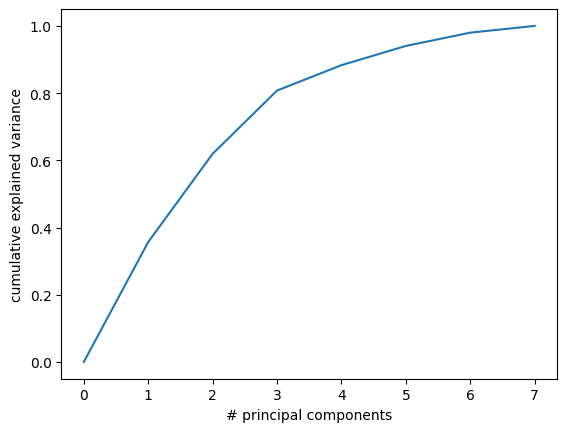

In [10]:
# 第一個位置為第一主成份的變異，所以要加0在第一個位置
var_plot = [0] + pca_10d.explained_variance_ratio_.tolist()

cum_explained_var_ratio = np.cumsum(var_plot)
plt.plot(cum_explained_var_ratio)
plt.xlabel('# principal components')
plt.ylabel('cumulative explained variance');

In [11]:
# 依照eigenvalue的大小排序共變異數矩陣的eigenvectors
pca = PCA(n_components=2, random_state=123)

# 注意我們是對標準化後的特徵做PCA
pca_trans = pca.fit_transform(df_std)

In [12]:
df_stats = df.describe().loc[['mean', 'std']]
df_stats.round(2)

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
mean,0.46,0.5,35.91,1.04,120954.42,0.81,0.74
std,0.50,0.5,11.72,0.60,38108.82,0.64,0.81


In [13]:
pcs = np.array(pca.components_)
print("PCA 算出來的欄位數:", pcs.shape[1])
print("你準備給它的名字數量:", len(df.columns))
df_pc = pd.DataFrame(pcs, columns=df.columns)
df_pc.index = [f"第{c}主成分" for c in['一', '二']]
df_pc.style\
    .background_gradient(cmap='PuBu', axis=None)\
    .format("{:.2}")

PCA 算出來的欄位數: 7
你準備給它的名字數量: 7


,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
第一主成分,-0.31,-0.19,0.33,0.16,0.52,0.49,0.46
第二主成分,0.46,0.51,0.31,0.64,0.12,0.015,-0.07


(np.float64(-3.4416480749506206),
 np.float64(5.979809025376065),
 np.float64(-2.942970822187512),
 np.float64(4.7858877851200345))

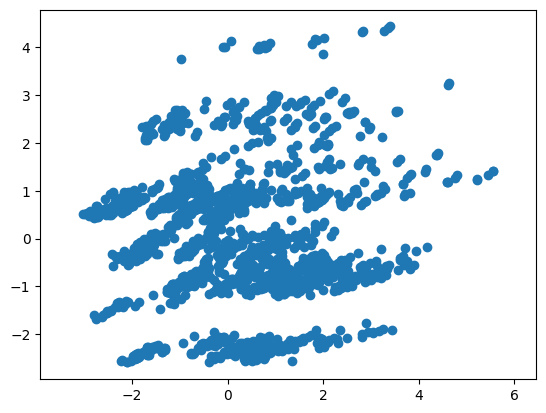

In [14]:
# 第一主成分顯示在 x 軸，第二主成分在 y 軸
plt.scatter(pca_trans[:, 0], pca_trans[:, 1])
plt.axis('equal')

In [15]:
peo_tb = pd.DataFrame(pca_trans, columns=['Pepore1', 'Pepore'])

peo_tb = pd.concat([df.reset_index(drop=True), peo_tb], axis=1)
peo_tb

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Pepore1,Pepore
0,0,0,67,2,124670,1,2,2.514746,0.834122
1,1,1,22,1,150773,1,2,0.344935,0.598146
2,0,0,49,1,89210,0,0,-0.651063,-0.680093
3,0,0,45,1,171565,1,1,1.714316,-0.579927
4,0,0,53,1,149031,1,1,1.626745,-0.440496
...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330
1996,1,1,27,1,117744,1,0,-1.114957,0.794727
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937
1998,1,1,24,1,97968,0,0,-2.241453,0.627108


In [16]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_std)

In [17]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(df_pca)

In [18]:
df['Segment'] = clusters
print(df.groupby('Segment').mean())

              Sex  Marital status        Age  Education         Income  \
Segment                                                                  
0        0.009634        0.173410  37.751445   0.859345  143536.915222   
1        0.092141        0.029810  31.571816   0.420054   99008.953930   
2        0.533582        0.731343  52.563433   2.007463  164420.186567   
3        0.867299        0.824645  31.383886   1.110190  102860.503555   

         Occupation  Settlement size  
Segment                               
0          1.279383         1.433526  
1          0.430894         0.368564  
2          1.283582         1.246269  
3          0.537915         0.312796  


In [19]:
from sklearn.datasets import load_digits
from sklearn.manifold import MDS

embedding = MDS(n_components=2)
mds_trans = embedding.fit_transform(df_std)

c:\Users\b7899\Eva_study\.venv\Lib\site-packages\sklearn\manifold\_mds.py:744: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.
  warnings.warn(
c:\Users\b7899\Eva_study\.venv\Lib\site-packages\sklearn\manifold\_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(


In [20]:
mds_tb = pd.DataFrame(mds_trans, columns=['dim1', 'dim2'])

df_mds_tb = pd.concat([df.reset_index(drop=True), mds_tb], axis=1)
df_mds_tb

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,dim1,dim2
0,0,0,67,2,124670,1,2,2,0.583030,-3.719816
1,1,1,22,1,150773,1,2,3,1.910252,-0.765722
2,0,0,49,1,89210,0,0,1,-2.033119,1.282174
3,0,0,45,1,171565,1,1,0,-0.776672,-1.772411
4,0,0,53,1,149031,1,1,0,-0.767182,-1.766630
...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,3,-0.933596,1.922712
1996,1,1,27,1,117744,1,0,3,1.133590,1.215291
1997,0,0,31,0,86400,0,0,1,-2.601246,1.597982
1998,1,1,24,1,97968,0,0,3,0.843022,2.395552


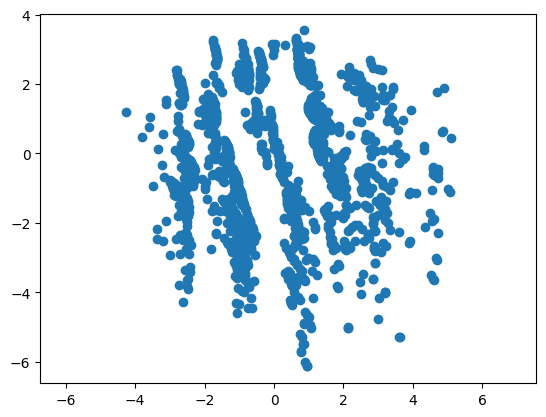

In [21]:
plt.scatter(mds_trans[:, 0], mds_trans[:, 1])
plt.axis('equal');